# Présentation du projet : 

## Contexte 

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


## Données 



Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

## Mission
### Contraintes


* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

### Livrable attendu ici
Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherches associées (non cleané, pour comprendre votre démarche).

# Ressources : 

## Les données et leur description :

Site d'extraction des données :

Traitement de texte (NLP) : 
* Le cours OC sur le traitement de text : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/
* 
* 
* 
* Les ressources compémentaires proposées dans le projet :
    * La doc sklearn : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    * Article - overview extraction de mot-clé : https://jios.foi.hr/index.php/jios/article/view/938/724
    * Tuto Kaggle Word2Vec : https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words
    * Livre NLTK (Natural Language Toolkit) : http://www.nltk.org/book/
    * Slide de présentation séminaire sur "Topic Models" Thibaut THONET : https://www.irit.fr/IRIS-site/images/seminairs/Thonet2016.pdf

# Présentation du notebook : 

Ce notebook présente mon analyse exploratoire, 
<!-- qui se résume à d'une part l'exploration des tables, et d'autre part l'extraction des features pour notre modèle de ségmentation des clients. -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

## extract list of text :
from bs4 import BeautifulSoup
import re
# from sklearn.feature_extraction.s import s# import ENGLISH_STOP_WORDS

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.cluster.hierarchy import cut_tree

from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.utils import tokenize
from gensim import corpora
from gensim import models
from gensim.models import FastText

# Première lecture des données :

In [2]:
df1 = pd.read_csv(data_path + "QueryResults_Id_0_50000.csv")
df1 = df1.set_index("Id")#.iloc[:1000,:]
print(df1.shape)
df1.head(3)

(50000, 22)


,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
Id,,,,,,,,,,,,,,,,,,,,,
4,1,7.0,NaN,2008-07-31 21:42:52,NaN,727,58688.0,<p>I want to use a <code>Track-Bar</code> to c...,8.0,NaN,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14.0,5,55.0,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
6,1,31.0,NaN,2008-07-31 22:08:08,NaN,306,21663.0,<p>I have an absolutely positioned <code>div</...,9.0,NaN,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7.0,0,12.0,NaN,NaN,CC BY-SA 4.0
7,2,NaN,4.0,2008-07-31 22:17:57,NaN,482,NaN,<p>An explicit cast to <code>double</code> lik...,9.0,NaN,...,2019-10-21 14:03:54,2019-10-21 14:03:54,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0


Visiblement seuls trois colonnes vont avoir un intérêt pour cette étude. Il s'agit des colonnes "Title" et "Body" comme ensemble d'entrée, et "Tags" comme sortie.

In [3]:
title = df1["Title"]
body = df1["Body"]
tags = df1["Tags"]

Il sera peut-être judicieux d'utiliser d'autres colonnes correspondant à la réponse de la communauté pour voir si le post a été tagué correctement. Il s'agirait de faire un  filtre sur les données d'apprentissage, puisqu'on ne veut pas apprendre des questions mal taguées. 

Pour le moment je vais me satisfaire de cet ensemble d'apprentissage. Comme c'est la première fois que je fais du NLP, je vais d'abord regarder comment faire un prétraitement sur les titres (parce que plus petit ensemble)

# 1 Preprocessing sur les tags 

Dans le projet, il est demandé de traiter le problème de deux manières : 
* Non supervisé : je pense faire appel au [module tags de la bibliothèque python nltk](http://www.nltk.org/api/nltk.tag.html#module-nltk.tag). Il pourra être pertinent de comparer cette approche avec les tags attribué par les internautes, ce pourquoi le preprocess des tags me paraissait pertinent à faire en premier lieu.
* Supervisé : pour cela, j'aurai besoin d'avoir extrait les tags des posts de slackoverflow pour les apprendre/tester les modèles. C'est ce que je compte faire dans cette partie.

Les tags sont dans un format entre balises, je vais les mettre dans une pd.DataFrame avec en colonne les différents tags et en ligne les posts. La matrice sera rempli du nombre d'occurence des tags. Elle sera donc sparse. 

In [5]:
tags = tags[~tags.isna()]
## test separation des tags entre balise
import re
print("test sur un post :", re.findall(r"\<([^>]*)",tags.iloc[0]))

## creation de la pd.DataFrame
df_tags = {}
for idx in tags.index : #[:1000] : 
    list_tags = re.findall(r"\<([^>]*)",tags.loc[idx])
    df_tags[idx] = pd.get_dummies(list_tags).sum()
df_tags = pd.DataFrame(df_tags).transpose()
df_tags = df_tags.fillna(0)
df_tags.head()

test sur un post : ['c#', 'floating-point', 'type-conversion', 'double', 'decimal']


,.htaccess,.htpasswd,.net,.net-1.0,.net-1.1,.net-2.0,.net-3.0,.net-3.5,.net-assembly,.net-attributes,...,zeroconf,zfs,zip,zipcode,zipinputstream,zipoutputstream,zlib,zos,zsh,zxspectrum
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Regardons comment sont répartis ces tags :

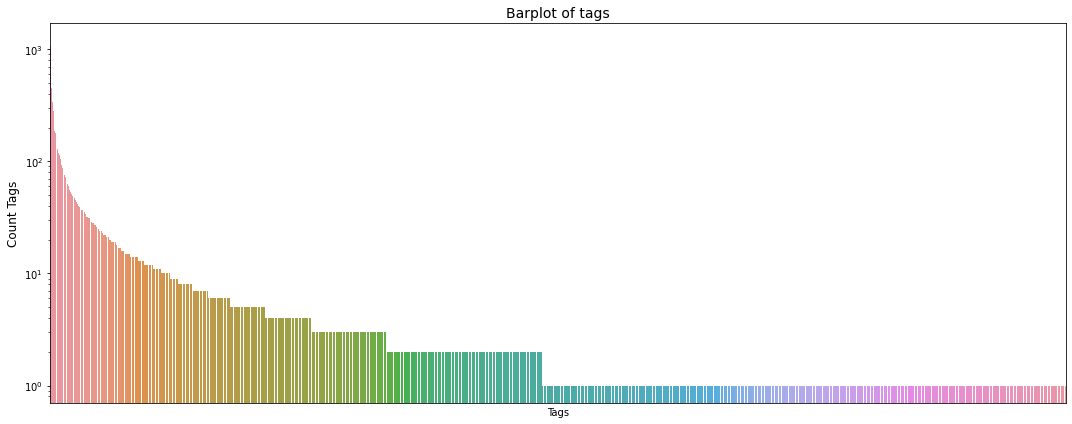

In [100]:
# df_tags.plot(kind="bar")
plt.rcParams["figure.figsize"] = (15,6)
tmp = df_tags.sum(axis=0).sort_values(ascending=False)
sns.barplot(y=tmp.values,x=tmp.index)
plt.xlabel("Tags", fontsize=10)
# plt.xticks(rotation=90, fontsize=6) # print xticks
plt.xticks([]) # remove xticks
plt.ylabel("Count Tags", fontsize=12)
plt.yscale("log")
plt.title("Barplot of tags", fontsize=14)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"barplot_tags.jpg")
plt.show()

Il serait intéressant de regrouper les tags similaires ##TODO

In [ ]:
df_tags.columns

 Comment rendre plus facile l'apprentisage de ces 402 tags ? Faire un clustering sur les tags, apprendre ces groupes de tags puis les tags dans chaque groupe ?

In [387]:
param_grid = {'n_components': np.arange(1, 20),
              'alpha': np.arange(0,1.1,0.1),
              'l1_ratio': np.arange(0,1.1,0.1)
             }
my_nmf = NMF(n_components=3, max_iter=1000, init ='nndsvdar')
my_score = frobenius_func
# res = pseudo_cv_reduce_dim(df_tags,my_nmf,param_grid, my_score, cv = 5)


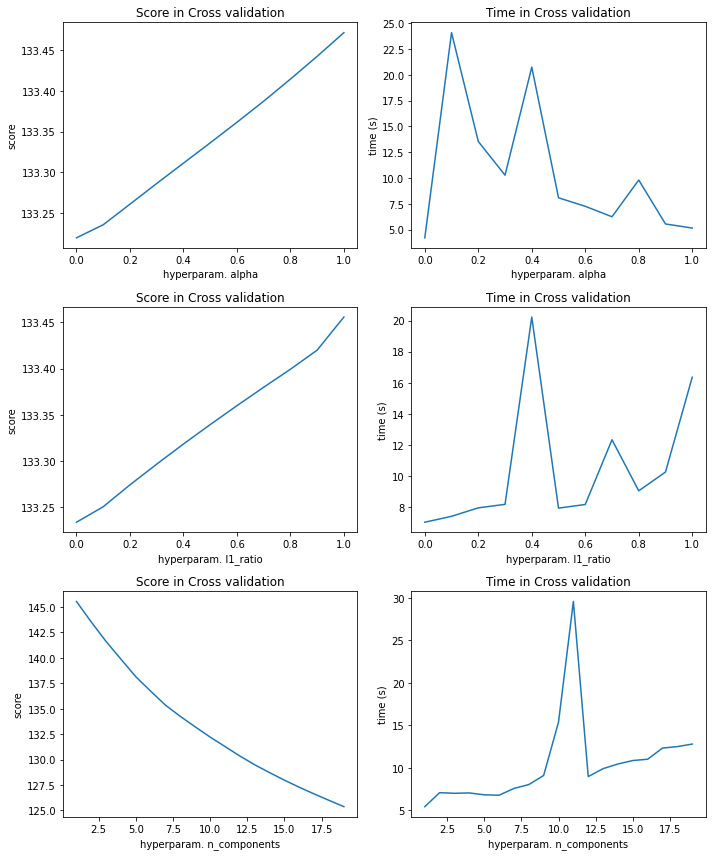

In [386]:
# with open(res_path+"reduce_dim/tags_NMF_res"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
with open(res_path+"reduce_dim/tags_NMF_res"+".pkl", "rb") as f :
    res = pickle.load(f)
dict_log_param = {"alpha":False, "l1_ratio":False, "n_components":False}
plot_cv_res(res,dict_log_param)
plt.tight_layout()

plt.savefig(res_path+"figures/"+"product_PCA_CV.jpg")

In [395]:
best_params = {"n_components":2, "alpha":0, "l1_ratio": 0,
               "init" :'nndsvdar', "max_iter" : 10000}


In [409]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# coeff_nmf = plot_coeffs(NMF(**best_params),df_tags, "tags")
# plt.subplot(1,2,2)
# coeffs_pca = plot_coeffs(PCA(),df_tags, "tags")
# plt.savefig(res_path+"figures/"+"product_PCA_coeffs.jpg")
# plt.show()

##TODO interprétation NMF

In [415]:
best_params["n_components"] = 17
nmf = NMF(**best_params)
nmf.fit(df_tags)
nmf_coeffs = pd.DataFrame(nmf.components_, columns = df_tags.columns,
                      index = ["ax_"+str(k) for k in np.arange(1,nmf.n_components+1)])
## compute
pca = PCA(n_components=best_params["n_components"])
pca.fit(df_tags)
pca_coeffs = pd.DataFrame(pca.components_, columns = df_tags.columns,
                      index = ["ax_"+str(k) for k in np.arange(1,pca.n_components+1)])

In [422]:
def plot_axis_coeffs(coeffs, my_meth_name = "NMF", axis_rank = [1,2] ):
    d1, d2 = axis_rank
    for colname in coeffs.columns :
        plt.scatter(x = coeffs.loc["ax_"+str(d1), colname], 
                    y = coeffs.loc["ax_"+str(d2), colname],
                    label = colname)
    plt.xlabel("coeff axis "+str(d1))
    plt.ylabel("coeff axis "+str(d2))
    plt.title(my_meth_name,fontsize=14)

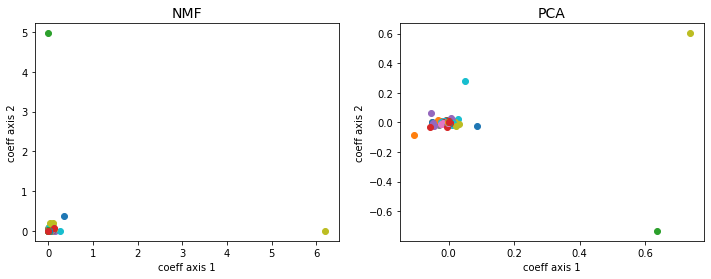

In [424]:
axis_rank = [1,2]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_axis_coeffs(nmf_coeffs,"NMF", axis_rank)
plt.subplot(1,2,2)
plot_axis_coeffs(pca_coeffs,"PCA", axis_rank)
plt.savefig(res_path+"figures/"+"tags_NMF_PCA_coeffs12.jpg")
plt.show()

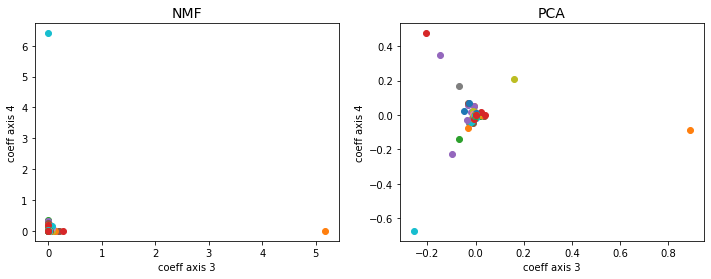

In [425]:
axis_rank = [3,4]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_axis_coeffs(nmf_coeffs,"NMF", axis_rank)
plt.subplot(1,2,2)
plot_axis_coeffs(pca_coeffs,"PCA", axis_rank)
plt.savefig(res_path+"figures/"+"tags_NMF_PCA_coeffs34.jpg")
plt.show()

# 2 Preprocessing sur les titres/corpus


## 2.1 En suivant le cours d'OC 
J'ai choisi de commencer par suivre les étapes [du cours d'OpenClassRoom sur les traitement textes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles). 

### Récupération et exploration du corpus de texte 
Je ne suis pas concernée par la partie "scrap" puisque j'ai déjà mon texte. 

Néansmoins, il y a deux points nécessaires à traiter a ce stade : 
1. Il faut sortir de la syntaxe html pour avoir un format text. Les balises de code semblent importante à garder, ne serait-ce que parce que certaines contiennent le langage de programmation.
2. je vais essayer d'insérer les titles dans les corpus, car il y a {{title.isna().sum()/title.shape[0]*100}}$\%$ de valeurs maquantes pour les titles. 

#### De HTML à text

In [4]:
body.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [5]:
def extract_text_btw_html(html):
#     html = title_+body_
    soup = BeautifulSoup(html)
    for script in soup(["script", "style"]):
        script.decompose()
    return(list(soup.stripped_strings))

# Use regular expressions to do a find-and-replace
def letter_only(my_text):
    return(re.sub("[^a-zA-Z]",   # The pattern to search for
                      " ",       # The pattern to replace it with
                      my_text ))  # The text to search

def from_list_of_sentences_to_tokens(list_text):
    tokens=[]
    for text in list_text[:20] :
        ## soit le code fait mqin depuis tuto kaggle
        text = letter_only(text.lower())
        text_token = nltk.word_tokenize(text)
#         ## soit tout fonction tout pret de nltk
#         text_token = tokenizer.tokenize(text.lower())
        
        tokens = tokens + text_token
    return(tokens)

In [6]:
# nltk.download('punkt')
posts = {}
posts_tokens = {}
for idx in body.index : 
    body_ = body.loc[idx]
    title_ = title.loc[idx]
    if pd.isna(title_) :
        text = str(body_)
    else :
        text = title_ + body_
    list_text = extract_text_btw_html(text)
    posts[idx]=  ' '.join(list_text)
    tokens = from_list_of_sentences_to_tokens(list_text)
    posts_tokens[idx] = tokens

In [7]:
print(posts[4])
print(posts_tokens[4])

How to convert a Decimal to a Double in C#? I want to use a Track-Bar to change a Form 's opacity. This is my code: decimal trans = trackBar1.Value / 5000;
this.Opacity = trans; When I build the application, it gives the following error: Cannot implicitly convert type decimal to double I have tried using trans and double , but then the Control doesn't work. This code worked fine in a past VB.NET project.
['how', 'to', 'convert', 'a', 'decimal', 'to', 'a', 'double', 'in', 'c', 'i', 'want', 'to', 'use', 'a', 'track', 'bar', 'to', 'change', 'a', 'form', 's', 'opacity', 'this', 'is', 'my', 'code', 'decimal', 'trans', 'trackbar', 'value', 'this', 'opacity', 'trans', 'when', 'i', 'build', 'the', 'application', 'it', 'gives', 'the', 'following', 'error', 'can', 'not', 'implicitly', 'convert', 'type', 'decimal', 'to', 'double', 'i', 'have', 'tried', 'using', 'trans', 'and', 'double', 'but', 'then', 'the', 'control', 'doesn', 't', 'work', 'this', 'code', 'worked', 'fine', 'in', 'a', 'past', 'vb

Maintenant que mes mots sont dans un dictionnaire de liste de mot, c'est à dire de tokens (de la même forme que dans le cours d'OC), je vais pouvoir reprendre des bouts de code de le cours pour avancer plus vite. 
#### Tokenization 

In [8]:
# tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats(list_tokens):
    corpora = list_tokens.copy()
    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats)

# Récupération des comptages
corpora = posts_tokens.copy()
freq, stats = freq_stats(posts_tokens)
df_tokens_stats = pd.DataFrame.from_dict(stats, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

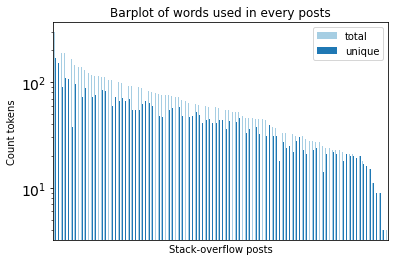

In [9]:
def plot_tokens_stats(df_tokens, figname=None):
    nb_colors = df_tokens.shape[1]
    df_tokens.plot(kind='bar', color=sns.color_palette("Paired", nb_colors),
                         title='Barplot of words used in every posts',
                         fontsize = 14,)
    plt.xticks([])
    plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
tmp = df_tokens_stats.sample(100).sort_values("total", ascending=False)
plot_tokens_stats(tmp, figname=figname)

Je trouve beaucoup trop lente la fonction "plot" de "pandas.DataFrame", et quitte à faire une fonction pour la lancer à plusieurs endroits, autant qu'elle soit plus rapide à l'exécution.

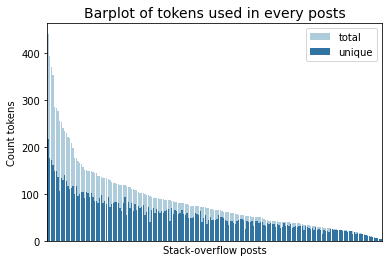

In [10]:
df_tokens = df_tokens_stats.sample(100)
def plot_tokens_stats(df_tokens, figname=None, ylog=False):
    df_tokens = df_tokens.sort_values("total", ascending=False)
    df_tokens = df_tokens.reset_index()
    nb_colors = df_tokens.shape[1]-1
    palette=sns.color_palette("Paired", nb_colors)
    for i,var in enumerate(df_tokens.columns[1:]):
        var_color = palette[i] 
        sns.barplot(x = "index", y = var, data=df_tokens,
                    order=df_tokens["index"],
                    color=var_color, label=var, 
                    log=ylog)
    plt.legend()
    plt.title('Barplot of tokens used in every posts',fontsize = 14)
    plt.xticks([])
#     plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()
# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
sample_token_stat = df_tokens_stats.sample(200)
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

In fine, ce qui va nous intéresser n'est pas la répartition des mots dans les posts, mais la répartition des mots pour les différents tags. Néansmoins, comme chaque post a plusieurs tags, il me parait bien plus pertinent de faire le nettoyage de ces tokens tel quel, et afficher le résultat par tags a posteriori (pas comme dans le TP, où les tokens sont affichés par artististe). 

#### Stopwords

Il ne me parait donc pas pertinent, comme dans le TP, de regarder ce que donne le même bar-plot, en retirant les mots en doublon (ici on n'a pas regroupé les tokens autre que pas post). Je propose de d'abbord faire les étapes de nettoyage et normalisation.

In [11]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

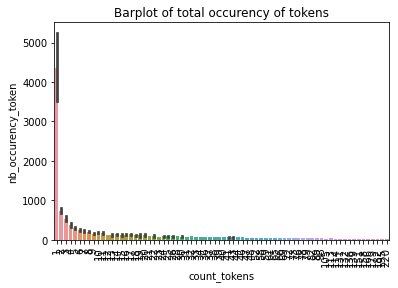

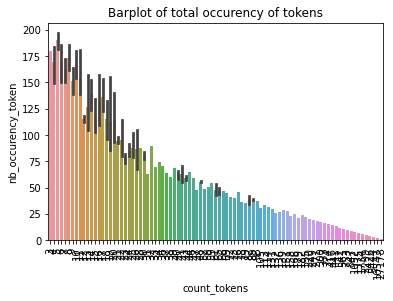

In [12]:
## Choix du seuil pour le nombre d'apparition des mots les plus frequents :
freq_count = pd.Series(freq_totale).value_counts()
freq_count = freq_count.reset_index()
freq_count = freq_count.rename(columns={"index":"nb_occurency_token", 
                                        0:"count_tokens"})
freq_count = freq_count.sort_values("count_tokens", ascending=False)
## drop non-freq words :
not_freq_tokens = freq_count[freq_count["nb_occurency_token"] <20].index
# freq_count = freq_count.drop(index=not_freq_tokens)
sns.barplot(data=freq_count.drop(index=not_freq_tokens), y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()
very_freq_tokens = freq_count[freq_count["nb_occurency_token"] >200].index
# freq_count = freq_count.drop(index=very_freq_tokens)
sns.barplot(data= freq_count.drop(index=very_freq_tokens), 
            y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()

Je fixe à 120 mots les plus fréquents : 

In [13]:
## Deuxièmement on extrait les mots les plus fréquents :
high_freq_token = [a_tuple[0] for a_tuple in freq_totale.most_common(120)]

In [14]:
## Troisièmement, on ajoute ces mots fréquents aux stopwords de nltk :
# nltk.download('stopwords')
sw = set()
sw.update(high_freq_token)
sw.update(tuple(nltk.corpus.stopwords.words('english')))


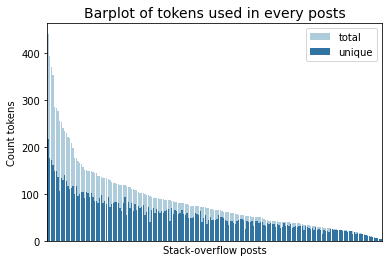

In [15]:
def freq_stats_corpora(list_tokens, stopwords=[]):
    stats, freq, corpora = dict(), dict(), dict()
    for k, v in list_tokens.items():
        corpora[k] = [w for w in list_tokens[k] if w not in list(stopwords)] 
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats, corpora)

# Récupération des comptages
corpora = posts_tokens.copy()
freq2, stats2, corpora2 = freq_stats_corpora(posts_tokens, sw)
df_tokens_stats = pd.DataFrame.from_dict(stats2, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens2_stopwords.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

#### Lemmatization 
Pour la partie de lemmatisation, comme le cours d'OC ne proposait qu'une radicalisation (car le texte était en français dans l'exemple), je me suis plutôt intéressée au [tuto de Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words). Après avoir creusé un peu plus, comme je n'avais pas plus d'information, et surtout que le stemming a l'air assez puissant et très bien décrit, je me suis finalement lancé là-dedans 

In [16]:

stemmer = EnglishStemmer()

def freq_stats_corpora3(list_tokens,stopwords=[]):     
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)


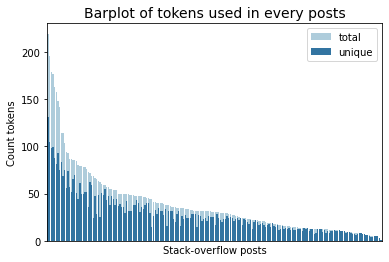

In [17]:
freq3, stats3, corpora3 = freq_stats_corpora3(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats3, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens3_radical.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

Pour la lemmatisation, j'ai trouvé [ce tuto](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) qui propose une implémentation assez claire. Il y avait des erreurs (une utilisation dépréciée), j'ai donc fini par aller [sur la page du paquet](https://spacy.io/). J'ai comparé le traitement 

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Process on a post to test the spacy syntax : 
text = " ".join(posts_tokens[4])
doc = nlp(text)
# print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decimal', 'c', 'track', 'bar', 'form', 'opacity', 'code', 'trackbar', 'value', 'opacity', 'tran', 'application', 'error', 'type', 'tran', 'control', 'work', 'code', 'past', 'vb', 'project']
Verbs: ['convert', 'want', 'use', 'change', 'build', 'give', 'follow', 'convert', 'double', 'try', 'use', 'work']


how to convert a decimal to a double in c i want to use a track bar to change a form s opacity this is my code decimal trans trackbar value this opacity trans when i build the application it gives the following error can not implicitly convert type decimal to double i have tried using trans and double but then the control doesn t work this code worked fine in a past vb net project

In [19]:
doc = nlp(" ".join(corpora3[4]))
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decim', 'doubl', 'track', 'bar', 'decim', 'trackbar', 'opac', 'build', 'give', 'follow', 'error', 'convert', 'decim', 'doubl', 'control', 'work', 'vb', 'project']
Verbs: ['convert', 'form', 'tran', 'tran', 'tran']


convert decim doubl track bar chang form opac decim tran trackbar opac tran build give follow error implicit convert decim doubl tri tran doubl control work fine past vb project

In [74]:
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
import spacy
tokens = posts_tokens[4]
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

['how', 'convert', 'decimal', 'double', 'c', 'want', 'use', 'track', 'bar', 'change', 'form', 'opacity', 'code', 'decimal', 'trackbar', 'value', 'opacity', 'tran', 'when', 'build', 'application', 'give', 'follow', 'error', 'implicitly', 'convert', 'type', 'decimal', 'double', 'try', 'use', 'tran', 'double', 'then', 'control', 'work', 'code', 'work', 'fine', 'past', 'vb', 'net', 'project']


Bon, du coup il a l'air préférable de faire la lemmatisation avant de faire les autres prétraitements. 

In [21]:

def from_post_to_tokens(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = lemmatization(tokens, allowed_postags=allowed_postags)
        ## save results
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

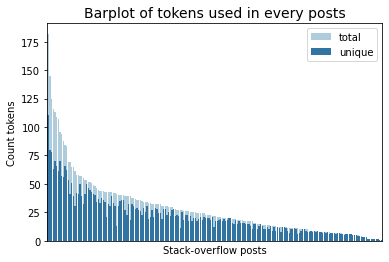

In [23]:
freq4, stats4, corpora4 = from_post_to_tokens(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats4, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens4_radical.jpg"
sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

Je propose de garder ces premiers traitements en première intension : 

In [75]:
## save results
data_lemmatized = []
for list_text in corpora4.values():
    text  = " ".join(list_text)
    data_lemmatized.append(text)

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

## transform into bag of words : 
# data_vectorized = {}
# for idx in corpora4.keys():
#     list_text = corpora4[idx]
#     text = " ".join(list_text)
#     data_vectorized[idx] = vectorizer.fit_transform(text)
data_vectorized = vectorizer.fit_transform(data_lemmatized)

Comme dans le tuto, je regarde la sparcité de ma matrice : 

In [27]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.396171662712961 %


# Classification non supervisée 
Passons maintenant à la classification. Au vu du prétraitement déjà effectué, il paraît naturel de commencer par la représentation "bag of words". Je propose de lancer un kmeans, et projeter les résultats avec tSNE. Ensuite, je regarderai ce que donne le kmeans sur le "tf-idf"

## 2.0 Différentes tentatives pour représenter les mots
## 2.0.1 Avec tSNE

Je commence par voir si des groupes se tracent dans la projection en deux dimensions de tSNE :

In [ ]:
n_cluster = 5
cls_meth = KMeans(init="k-means++")
cls_meth.set_params(n_clusters  = n_clusters)
cls_meth.fit(X_std)
labels = pd.Series(cls_meth.labels_)
    
for perplexity in np.arange(5,50,10):
    X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(X_std)
    X_embedded = pd.DataFrame(X_embedded,
                              columns=["axis"+str(k+1) for k in range(2)])
    ## plot 
    plt.figure(figsize=(10,8))
    for clust in np.unique(labels.values) : 
        index_cluster = labels[labels == clust].index
        plt.scatter(x=X_embedded.loc[index_cluster,"axis1"], 
                    y=X_embedded.loc[index_cluster,"axis2"], 
                    alpha = 0.5, marker="^", s=5, 
                    label="cluster_"+str(clust),
                    color=color_palette[clust])
    plt.xlabel("tSNE axis 1")
    plt.ylabel("tSNE axis 2")
#     plt.legend(bbox_to_anchor=(1.25, 1))
    plt.title("tSNE on posts clustering with perplexity = "+str(perplexity))
    plt.savefig(res_path+"figures/"
                +"posts_tSNE_kmeans70_perplex"+str(perplexity)+".jpg",
               bbox_inches='tight')
    plt.show()

## 2.1 Kmeans
### 2.1.1 Bag of words

J'ai déjà la représentation en "bag of words", je vais donc lancer KMeans avec différents nombres de clusters pour choisir le plus adapté, en utilisant la méthode du coude sur l'inertie de clustering.

In [28]:
## Standardization : 
my_std = StandardScaler(with_mean=False)#mean false because sparce
X = data_vectorized
my_std.fit(X)
X_std = my_std.transform(X)

# list_n_clusters = np.arange(2,70,2)
# # Elbow-Method/SSD 
# ssd = []
# for num_clusters in list_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
#     kmeans.fit(X_std)
#     ssd.append(kmeans.inertia_)
    
# # plot the SSDs for each n_clusters
# plt.plot(list_n_clusters,ssd)
# plt.xlabel("Number of clusters")
# plt.ylabel("Inertia")
# plt.title("Elbow method to set the best number of cluster\n for kmeans on orders")
# plt.savefig(res_path+"figures/"+"bag_of_words_kmeans_inertia.jpg")
# plt.show()

La méthode n'est pas concluante, puisqu'il faudrait un nombre de clusters très important pour avoir un résultat pertinent (on n'a toujours pas de coude à 70 cluster). 

Je vais tout de même regarder comment représenter mes résultats en deux dimensions, avec tSNE. Pour cela, je vais faire tourner tSNE avec différentes perplexités, en ajoutant la coloration donnée par le KMeans. 

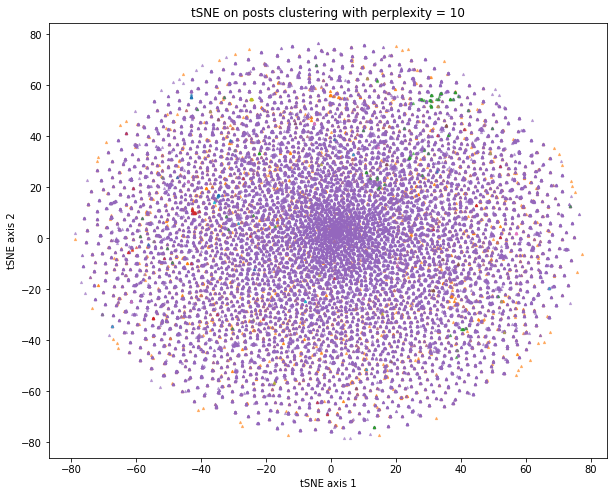

In [232]:
n_clusters = 50
n_around_elbow = [n_clusters]
color_palette = my_color_set
# color_palette = sns.color_palette("magma", max(n_around_elbow))
for n_clusters in n_around_elbow:
    cls_meth = KMeans(init="k-means++")
    cls_meth.set_params(n_clusters  = n_clusters)
    cls_meth.fit(X_std)
    labels = pd.Series(cls_meth.labels_)
    
perplexity = 10 
X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(X_std)
X_embedded = pd.DataFrame(X_embedded,
                          columns=["axis"+str(k+1) for k in range(2)])
## plot 
plt.figure(figsize=(10,8))
for clust in np.unique(labels.values) : 
    index_cluster = labels[labels == clust].index
    plt.scatter(x=X_embedded.loc[index_cluster,"axis1"], 
                y=X_embedded.loc[index_cluster,"axis2"], 
                alpha = 0.5, marker="^", s=5, 
                label="cluster_"+str(clust),
                color=color_palette[clust])
plt.xlabel("tSNE axis 1")
plt.ylabel("tSNE axis 2")
#     plt.legend(bbox_to_anchor=(1.25, 1))
plt.title("tSNE on posts clustering with perplexity = "+str(perplexity))
plt.savefig(res_path+"figures/"
            +"posts_tSNE_kmeans70_perplex"+str(perplexity)+".jpg",
           bbox_inches='tight')
plt.show()

Les posts ne sont pas bien représentés dans cette espace ... et le clustering ne donne rien de lisible

### 2.1.2. Avec tf-idf

In [35]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=[])
data_tfidf = tfidf.fit_transform(data_lemmatized)

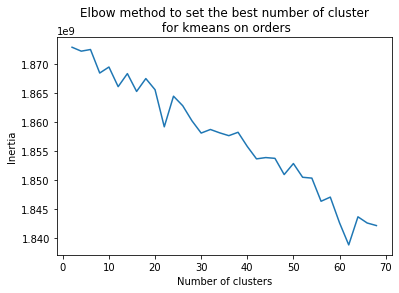

In [135]:
## Standardization : 
my_std = StandardScaler(with_mean=False)#mean false because sparce
X = data_tfidf
my_std.fit(X)
X_std = my_std.transform(X)

list_n_clusters = np.arange(2,70,2)
# Elbow-Method/SSD 
ssd = []
for num_clusters in list_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(X_std)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(list_n_clusters,ssd)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method to set the best number of cluster\n for kmeans on orders")
plt.savefig(res_path+"figures/"+"tfidf_kmeans_inertia.jpg")
plt.show()

Ok, ce n'est pas beaucoup mieux que le bag of words. Je passe donc directement aux plongements de mots.

In [25]:
## TODO : Bug sur le Tuto 
## http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html

# sentences = data_lemmatized
# pipe = make_pipeline(CountVectorizer(),TfidfVectorizer())
# # pipe.fit(sentences)
# # data_tfidf = pipe.transform(sentences)
# data_lemmatized

### 2.1.3 Plongements de mots 
#### Word to vect
Comme le kmeans tel quel est très mauvais, je me suis donc muni d'outils pré-entrainés pour réduire la dimension et la sparcité de ma matrice de design. Pour cela, j'ai utilisé la bibliothèque "gensim", et [le tuto suivant](https://rare-technologies.com/word2vec-tutorial/). 

In [77]:
## Load the text to save RAM : 
# class MySentences(object):
#     def __init__(self, dirname):
#         self.dirname = dirname
 
#     def __iter__(self):
#         for fname in os.listdir(self.dirname):
#             for line in open(os.path.join(self.dirname, fname)):
#                 yield line.split()
 
# sentences = MySentences('/some/directory') # a memory-friendly iterator
# model = gensim.models.Word2Vec(sentences)
## Elsewise :
sentences = data_lemmatized
model = models.Word2Vec(sentences)

In [183]:
## attention : copie pour debug
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

def from_post_to_tokens_gensim(dict_posts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    corpora = {}#dict_posts.copy()
    for idx in dict_posts.keys() :
        doc = dict_posts[idx]
        ## preprocess from gensim : 
        tokens = tokenize(doc, lowercase=True, deacc=True, 
                           encoding='utf8', errors='strict')
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
#         tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = " ".join(lemmatization(tokens, allowed_postags=allowed_postags))
        ## save results
        corpora[idx] = tokens
    return(corpora)

In [187]:
# corpora = from_post_to_tokens_gensim(posts, stopwords=sw)
# with open(res_path+"posts_cleanned_corpora"+".pkl", "wb") as f :
#     pickle.dump(corpora, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"posts_cleanned_corpora"+".pkl", "rb") as f :
    corpora = pickle.load(f)
    
sentences = corpora.values()

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [188]:
model = models.Word2Vec(sentences)

In [209]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

Text(0, 0.5, 'tSNE Axis 2')

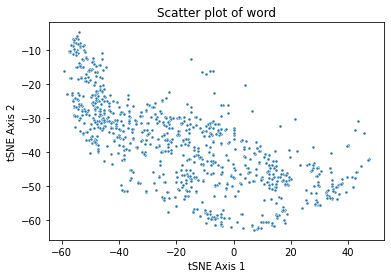

In [210]:
sns.scatterplot(x=x_vals[:1000], y=y_vals[:1000], marker=".")
plt.title("Scatter plot of word")
plt.xlabel("tSNE Axis 1")
plt.ylabel("tSNE Axis 2")

In [218]:
from gensim.models import Phrases
docs = list(corpora.values())
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


In [227]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [228]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5506
Number of documents: 50000


In [1]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

NameError: name 'dictionary' is not defined

#### Entrainement du word2vect avec gensim :
Le gros soucis de ce plongement est qu'il est complètement dépendant de la base d'entrainement. Pour retirer le biais, j'ai entrainé un word2vect sur d'autres posts de stackoverflow :

In [47]:
df2 = pd.read_csv(data_path + "QueryResults_Id_100m_150m.csv")
df2 = df2.set_index("Id")
training_posts = {}
for idx in df2.index : 
    body_ = df2["Body"].loc[idx]
    title_ = df2["Title"].loc[idx]
    if pd.isna(title_) :
        text = str(body_)
    else :
        text = title_ + body_
    list_text = extract_text_btw_html(text)
    training_posts[idx]=  ' '.join(list_text)

Tant qu'à faire, je teste une autre implémentation pour le pre-process :

In [48]:
def from_post_to_tokens_gensim(dict_posts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    corpora = dict_posts.copy()
    for idx in corpora.keys() :
        doc = corpora[idx] 
        ## preprocess from gensim : 
        tokens = tokenize(doc, lowercase=True, deacc=True, 
                           encoding='utf8', errors='strict')
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
#         tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = lemmatization(tokens, allowed_postags=allowed_postags)
        ## save results
        corpora[idx] = tokens
    return(corpora)

In [52]:
training_sw = tuple(nltk.corpus.stopwords.words('english'))
training_tokens = from_post_to_tokens_gensim(training_posts,stopwords=training_sw)
## gensim transformations : 
training_processed_corpus = training_tokens.values()
training_dictionary = corpora.Dictionary(training_processed_corpus)
training_bow_corpus = [training_dictionary.doc2bow(text) for text in training_processed_corpus]
# training_tfidf_corpus = TfidfVectorizer(training_bow_corpus)

In [54]:
model = models.Word2Vec(workers=6)  # an empty model, no training yet
model.build_vocab(training_processed_corpus)  # can be a non-repeatable, 1-pass generator
# model.train(other_sentences)  # can be a non-repeatable, 1-pass generator


In [56]:
# model = models.TfidfModel(bow_corpus, normalize=True)

my_models = {  
            "Tfidf" : models.TfidfModel(id2word=training_dictionary,normalize=True),
            "Fast Text" : models.FastText(vector_size=4, window=3, min_count=1),  # instantiate
            "Latent Semantic Indexing" : models.LsiModel(id2word=training_dictionary, num_topics=300),
#             "Random Projections" : models.RpModel(training_dictionary,num_topics=500),
            "Latent Dirichlet Allocation" : models.LdaModel(id2word=training_dictionary, num_topics=100),
#             "Hierarchical Dirichlet Process" :  models.HdpModel(id2word=training_dictionary)
         }

In [59]:
model = my_models["Latent Dirichlet Allocation"].build_vocab(training_bow_corpus)

AttributeError: 'LdaModel' object has no attribute 'build_vocab'

In [188]:
classifier = nltk.DecisionTreeClassifier.train(train_set)

[(138, 1.0)]


In [249]:
models.TfidfModel(bow_corpus,normalize=True).__getitem__(bow_corpus[10])

[(15, 0.08512230136528105),
 (26, 0.022889886537472155),
 (62, 0.3864756782823179),
 (69, 0.11750743117791425),
 (111, 0.0547415827854232),
 (146, 0.0951459124079985),
 (154, 0.13830943367313206),
 (173, 0.09051160850603689),
 (203, 0.11938723581286087),
 (204, 0.10062700012911104),
 (205, 0.07585537714385915),
 (206, 0.2383936307988265),
 (207, 0.2772348195354719),
 (208, 0.16593528110300385),
 (209, 0.11449495662295334),
 (210, 0.13964149293811745),
 (211, 0.16162744457666306),
 (212, 0.08588407091659489),
 (213, 0.12719667067928805),
 (214, 0.22290967889485286),
 (215, 0.18310504908887523),
 (216, 0.33503850701487636),
 (217, 0.10929009699994925),
 (218, 0.12256299645600044),
 (219, 0.09882939530339795),
 (220, 0.1181219421812283),
 (221, 0.11021745470367703),
 (222, 0.3074391703566212),
 (223, 0.1170166188099143),
 (224, 0.31267698824496065),
 (225, 0.12648537898229548),
 (226, 0.09775987684184677),
 (227, 0.08098044754755061),
 (228, 0.14017474230593135)]